## Open notebook in:
| Colab                   Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH10/ch10_safeguard_LLMs.ipynb)                                              

# About this notebook

In this notebook, you will use the LLM attribution functionality introduced in Captum v0.7, which makes it a breeze to applying the attribution algorithms to interpret the LLMs in text generation. This code is inspired by the tutorial in this paper https://arxiv.org/abs/2312.05491

You, will use Llama2 (13b-chat) as an example and use both perturbation-based and grandient-based algrithms respectively to see how the input prompts lead to the generated content.

#Install requirements

In [ ]:
!pip install -q transformers==4.51.3 accelerate==1.10.1 bitsandbytes==0.47.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.6 MB/s eta 0:00:00


In [ ]:
!pip install captum==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 115.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you h

In [ ]:
import bitsandbytes as bnb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from huggingface_hub import HfApi, HfFolder
import random
import sys


from captum.attr import (
    FeatureAblation,
    ShapleyValues,
    LayerIntegratedGradients,
    LLMAttribution,
    LLMGradientAttribution,
    TextTokenInput,
    TextTemplateInput,
    ProductBaselines,
)

In [ ]:
import os
from huggingface_hub import HfFolder


hf_token = input("Enter your Hugging Face access token: ").strip()
os.environ["HF_TOKEN"] = hf_token

HfFolder.save_token(hf_token)

print("Hugging Face token saved successfully.")


In [ ]:
def get_gpu_memory_gb(gpu_index=0):
    """Returns the total memory of the specified GPU in GB."""
    total_memory_bytes = torch.cuda.get_device_properties(gpu_index).total_memory
    total_memory_gb = total_memory_bytes / (1024 ** 3)  # Convert bytes to GB
    return total_memory_gb

def load_model(model_name):
    # Configure BitsAndBytes for efficient model quantization
    bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                    bnb_4bit_use_double_quant=True,
                                    bnb_4bit_quant_type="nf4",
                                    bnb_4bit_compute_dtype=torch.bfloat16)

    n_gpus = torch.cuda.device_count()
    device_map = "auto"
    memory_config = {i: f"{get_gpu_memory_gb(i) - 1}GB" for i in range(n_gpus)}

    model = AutoModelForCausalLM.from_pretrained(model_name,
                                                 quantization_config=bnb_config,
                                                 device_map=device_map,
                                                 max_memory=memory_config,
                                                 use_auth_token=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
    tokenizer.pad_token = tokenizer.eos_token  # Needed for LLaMA tokenizer

    return model, tokenizer

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

model, tokenizer = load_model(model_name)


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Let's test the model with a simple prompt and take a look at the output.

In [ ]:
eval_prompt = "Nicole lives in Zurich, Switzerland and is a Data Scientist. Her personal interests include"

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    output_ids = model.generate(model_input["input_ids"], max_new_tokens=12)[0]
    response = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Nicole lives in Zurich, Switzerland and is a Data Scientist. Her personal interests include hiking, photography, and trying new recipes in the kitchen.


## Perturbation-based Attribution

Now that you have the model setup, you can start with the simplest `FeatureAblation`, which ablates each of the features of this string to see how it affects the predicted probability of the target string.

In [ ]:
fa = FeatureAblation(model)

llm_attr = LLMAttribution(fa, tokenizer)

The `llm_attr` functions similarly to the encapsulated attribution method it wraps, offers an `.attribute()` function. This function processes model inputs to generate attribution scores for specific features of interest. However, Captum's default approach to attribution involves manipulating PyTorch tensors directly, which may not align with our needs for LLM analysis. In LLM contexts, we're often more interested in interpretability at the text level, such as the impact of modifying or removing segments of text, rather than altering the less interpretable tensor representations of token indices. To bridge this gap, we introduce an adapter design named `InterpretableInput`. This design facilitates the conversion between text-based inputs and tensors, guiding Captum on how to effectively engage with these more meaningful forms of input. Consequently, `llm_attr `is designed to work with InterpretableInput, accommodating text-based inputs as arguments for more intuitive and relevant analysis.

In [ ]:
inp = TextTokenInput(
    eval_prompt,
    tokenizer,
    skip_tokens=[1],  # skip the special token for the start of the text <s>
)

target = "hiking, skiing, and playing the piano."

attr_res = llm_attr.attribute(inp, target=target)

You can get the attribution tensors with `FeatureAblation` attribution result of our LLM.

You can visualize the results and plot the token attribution to view the relations between input and output tokens.

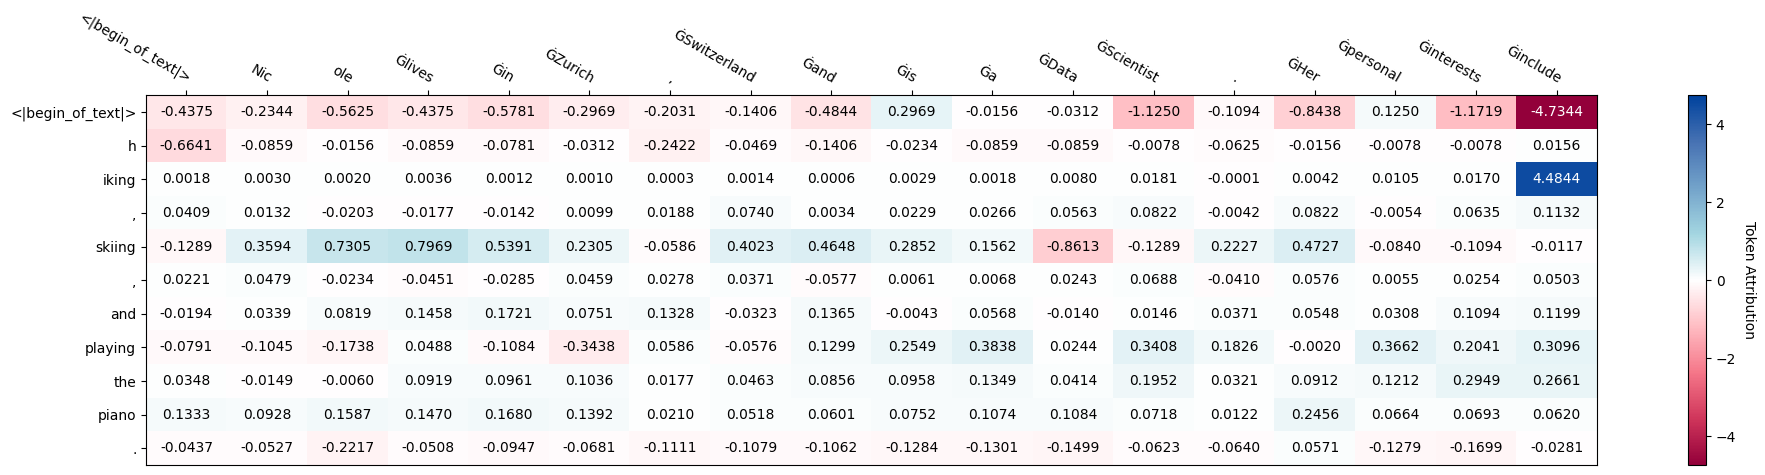

In [ ]:
attr_res.plot_token_attr(show=True)

Defining each token as an interpretable feature for perturbation might not always be practical or meaningful. This is because the tokenization process in modern LLMs can split a single word into multiple tokens, rendering the individual tokens less interpretable on their own.

To address this, Captum introduces a more customizable class for interpretable input, `TextTemplateInput`. This class allows users to define specific text segments (such as words or phrases) as the interpretable features. For example, in our provided prompt, which includes details like name, city, state, occupation, and pronoun, we can designate these segments as the interpretable features for analysis.

The goal of interpretation can be directed towards any text generation outcomes we find noteworthy. This approach offers a more granular and relevant analysis by focusing on the parts of the text that carry specific meanings or implications.

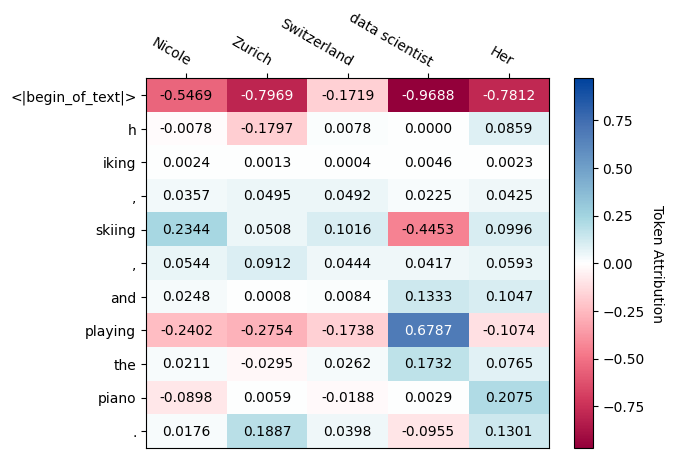

In [ ]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} personal interests include",
    values=["Nicole", "Zurich", "Switzerland", "data scientist", "Her"],
)

target = "hiking, skiing, and playing the piano."

attr_res = llm_attr.attribute(inp, target=target)

attr_res.plot_token_attr(show=True)

Perturbation-based algorithms determine attributions by switching features between states of "presence" and "absence." In this context, Captum enables you to specify of baselines, or reference values, for when a feature is considered absent. By default, `TextTemplateInput` assigns an empty string '' as the baseline for all features, effectively simulating the removal of text segments. However, this approach might not always be ideal, especially if it results in out-of-distribution scenarios. For instance, removing the "name" feature could strip the prompt of its subject, rendering it less coherent or meaningful.

To enhance this process, we can manually adjust the baselines to alternatives that maintain the context and coherence of the original text, ensuring that the analysis remains aligned with naturally occurring data distributions.

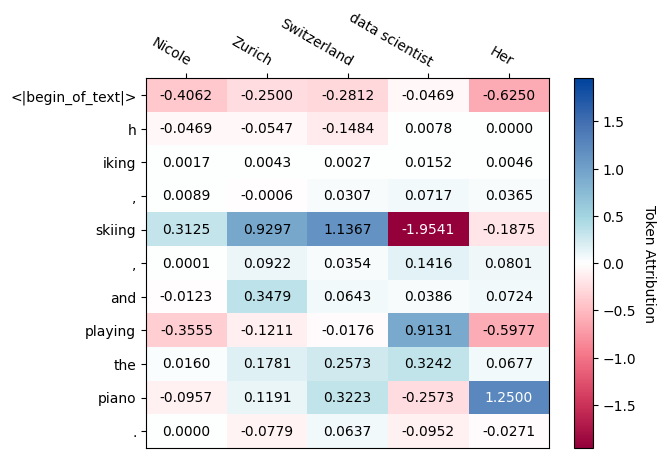

In [ ]:
inp = TextTemplateInput(
    template="{} lives in {}, {} and is a {}. {} personal interests include",
    values=["Nicole", "Zurich", "Switzerland", "data scientist", "Her"],
    baselines=["Elon", "Los Angeles", "United States", "businessman and investor", "His"],
)

attr_res = llm_attr.attribute(inp, target=target)

attr_res.plot_token_attr(show=True)